# Import Packages

In [1]:
# importing all the necessary packages
import pandas as pd # Dataframe package
import matplotlib.pyplot as plt # Plotting package
import numpy as np # Numerical computation package
import seaborn as sns # Plotting package
from sklearn.neural_network import MLPRegressor # neural network 
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from PIL import Image
from datetime import date, timedelta
from datetime import datetime

np.random.seed(1) # Set the random seed so that the results stay the same

# Neural Network with MLP Regressor

In [2]:
# Importing the data and splitting it into a train and test set to work with
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

## Hyperparameter Tuning

### 1. Establish Base Scenario

In [3]:
# Initialize a neural network with the default parameters 
nnet_base = MLPRegressor(random_state=42)

In [4]:
# Scale the data to work so it is less sensitive to feature scaling 
# normally we wouldn't use scaling if we already applied PCA to our data
# MLP Regressor doesn't work otherwise and has problems with matrix multiplication
# therefore we use scaling of the features and outputs in this prediction model
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest)
Xtest_scaled = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std()
ytest_scaled = (ytest - mu) / sigma
ytrain_scaled = (ytrain - mu) /sigma

In [5]:
# creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# defining a function to fit the scenario and evaluate it
def scenario_fit_evaluate_scaled(model, display_name, scenario, traindataX_sc, traindatay_sc, testdataX_sc, testdatay_sc):
    global comparison
    # Fit the network to the scaled train data
    scenario.fit(traindataX_sc, traindatay_sc)

    # Make predictions
    ypred_train_scaled = scenario.predict(traindataX_sc)
    ypred_scaled = scenario.predict(testdataX_sc)

    # Reconstruct outputs and scale back predictions
    ytest = testdatay_sc * sigma + mu
    ytrain = traindatay_sc * sigma + mu
    ypred_train = ypred_train_scaled * sigma + mu
    ypred = ypred_scaled * sigma + mu
    # the network predicts negative values because it is not possible to put an activation function on the output layer
    # MLPRegressor uses the activation function only on the hidden layers
    # Negative Values make no sense in our case, therefore we fix it and tell the network that all negative values
    # should equal to zero
    ypred[ypred < 0] = 0

    # Compute the MAE
    mae_train = mean_absolute_error(ytrain, ypred_train)
    mae_test = mean_absolute_error(ytest, ypred)
    # Comute R^2
    r2_train = r2_score(ytrain, ypred_train)
    r2_test = r2_score(ytest, ypred)

    # adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("outputs/comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [6]:
scenario_fit_evaluate_scaled("MLP Regressor", "Base Scenario", nnet_base, 
    Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

           Model       Scenario   MAE_train   MAE_test  R2_train   R2_test
0  MLP Regressor  Base Scenario  346.964702  458.80479   0.96515  0.940915


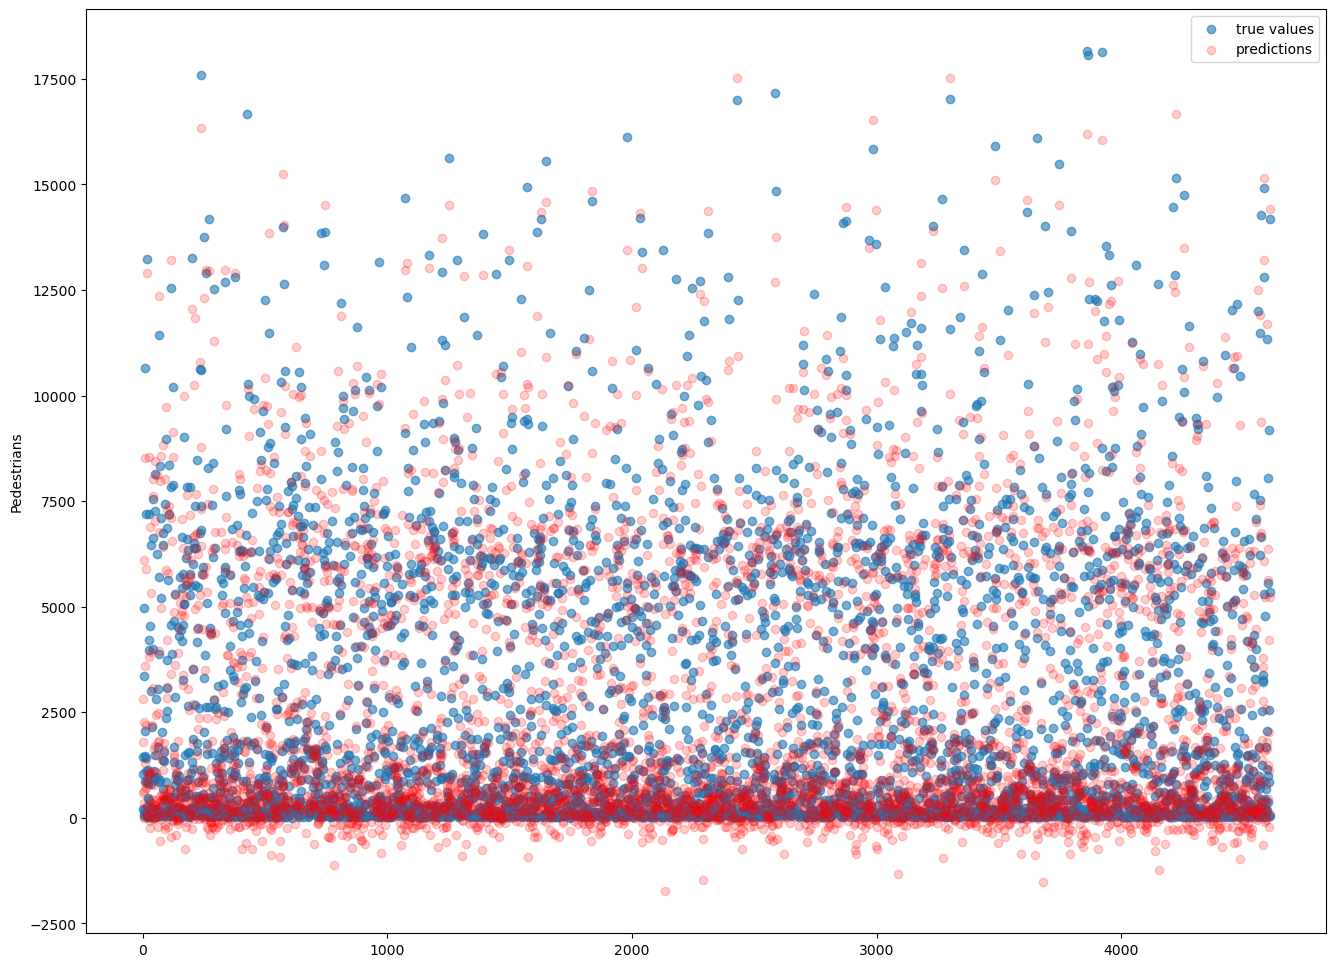

In [7]:
def plot_baseline_scaled(model, Xtest_scaled, ytest):
    # plot the results to see the results of our base scenario
    fig, ax = plt.subplots(figsize=(16, 12))

    #create a linspace to match the y-values
    xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

    # plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="true values", alpha=0.6)

    # plot the predictions
    ypred_scaled = model.predict(Xtest_scaled)
    ypred = ypred_scaled * sigma + mu
    ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)
    # there are negative values as a prediction of pedestrians because with MLP Regressor it is not possible to 
    # put an activation function on the output layer, it only works on the hidden layers
    # therefore in further predictions all values of ypred < 0 are going to be 0, so the scenario makes sense

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()

# apply the funtion to the data and calculations    
plot_baseline_scaled(nnet_base, Xtest_scaled, ytest)

### 2. Analyze the Influence of the Different Parameters

In [23]:
# conduncting the parameter analysis on the most used parameters for optimization
# how many hidden layers with how many neurons are we going to use
# 100 is the default value, other values chosen randomly to see the effect of more layers
hidden_layer_sizes = [(100,), (32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)]
# activation function that is going to be used on the hidden layers, relu is the default value
activations = ["relu", "logistic", "tanh", "identity"]
# the solver which optimizes the weights, adam is the default value
solvers = ["sgd", "adam"]
# regularization: avoids overfitting, 0.0001 is the default value
alphas = np.linspace(0.00001, 0.001, 50)
# how high is the initial learing rate, 0.001 is the default value
learing_rate_inits = np.linspace(0.001, 0.01, 50)
# number of epochs, 200 is the default value
# often it doesn't converge then so we start at 1000
max_iters = range(1000, 2000, 250)

names_parameters = ["hidden_layer_size", "activation", "solver", "alpha", "learning_rate_init", "max_iter"]

In [11]:
# creating a dataframe to save the results
results = pd.DataFrame(columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter_scaled(model, param, param_values, initialize_model):
    global results
    for param_value in param_values:
        nnet_param = initialize_model(param_value)
        # Fit the network to the train data
        nnet_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_param_train_scaled = nnet_param.predict(Xtrain_scaled)
        ypred_param_scaled = nnet_param.predict(Xtest_scaled)

        # Reconstruct outputs and scale predictions
        ypred_param_train = ypred_param_train_scaled * sigma + mu
        ypred_param = ypred_param_scaled * sigma + mu
        ypred_param[ypred_param < 0] = 0 # all neg values equal zero to make sense
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_param_train)
        mae_param_test = mean_absolute_error(ytest, ypred_param)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_param_train)
        r2_param_test = r2_score(ytest, ypred_param)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[model, param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Model", "Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])

# apply the function to the different parameters
test_parameter_scaled("MLP Regressor", "hidden_layer_size", hidden_layer_sizes, lambda value: MLPRegressor(hidden_layer_sizes=value, random_state=72))
test_parameter_scaled("MLP Regressor", "activation", activations, lambda value: MLPRegressor(activation=value, random_state=72))
test_parameter_scaled("MLP Regressor", "solver", solvers, lambda value: MLPRegressor(solver=value, random_state=72))
test_parameter_scaled("MLP Regressor", "alpha", alphas, lambda value: MLPRegressor(alpha=value, random_state=72))
test_parameter_scaled("MLP Regressor", "learning_rate_init", learing_rate_inits, lambda value: MLPRegressor(learning_rate_init=value, random_state=72))
test_parameter_scaled("MLP Regressor", "max_iter", max_iters, lambda value: MLPRegressor(max_iter=value, random_state=72))

# merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("outputs/param_testing.csv", sep=";", index=False)

In [7]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("outputs/param_testing.csv", sep=";")
param_testing

,Model,Parameter,ParameterValue,MaeTrain,MaeTest,R2Train,R2Test
0,MLP Regressor,hidden_layer_size,"(100,)",347.696832,441.015174,0.964892,0.943029
1,MLP Regressor,hidden_layer_size,"(32, 64, 32)",297.319744,429.473338,0.972019,0.931705
2,MLP Regressor,hidden_layer_size,"(64, 128, 64)",297.511867,434.913581,0.973874,0.927148
3,MLP Regressor,hidden_layer_size,"(32, 64, 128, 64, 32)",244.434975,447.374537,0.979625,0.919673
4,MLP Regressor,activation,relu,347.696832,441.015174,0.964892,0.943029
...,...,...,...,...,...,...,...
109,MLP Regressor,learning_rate_init,0.01,429.676135,473.345627,0.954854,0.944542
110,MLP Regressor,max_iter,1000,347.696832,441.015174,0.964892,0.943029
111,MLP Regressor,max_iter,1250,347.696832,441.015174,0.964892,0.943029
112,MLP Regressor,max_iter,1500,347.696832,441.015174,0.964892,0.943029


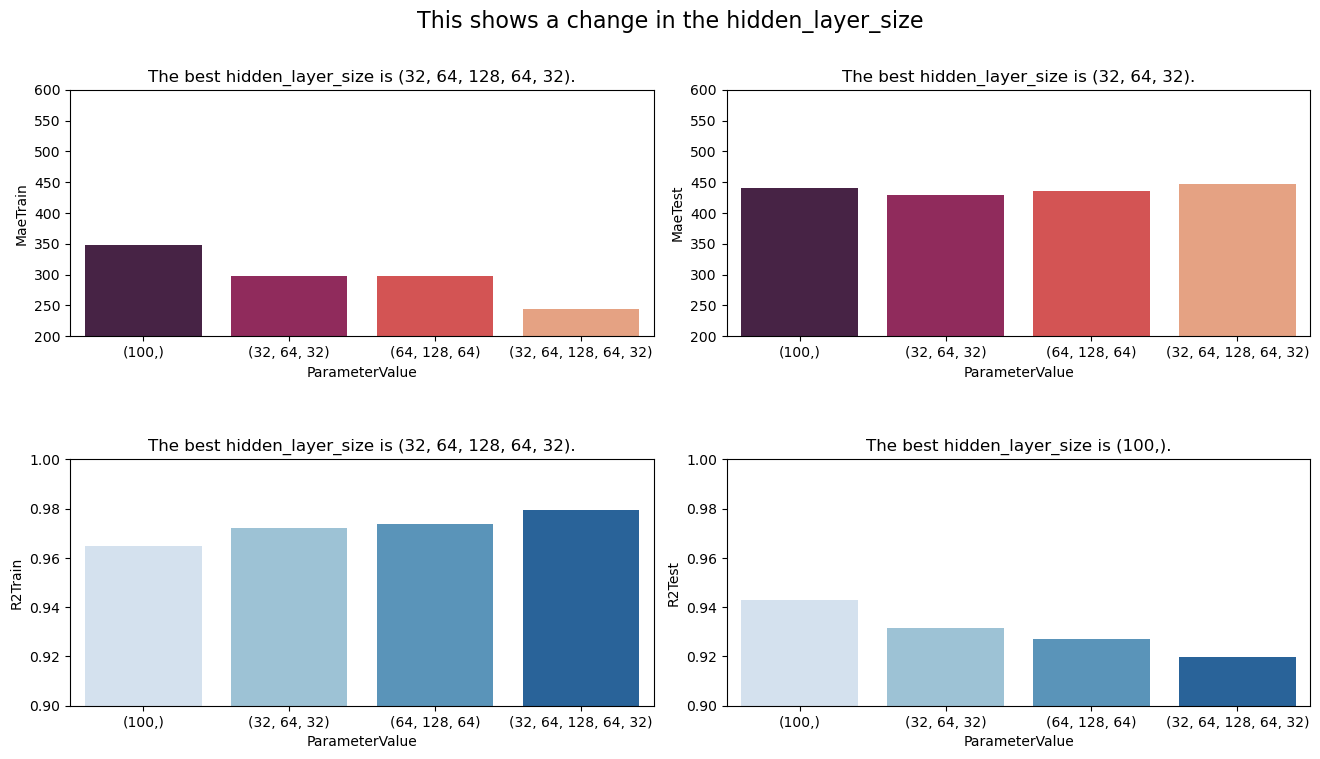

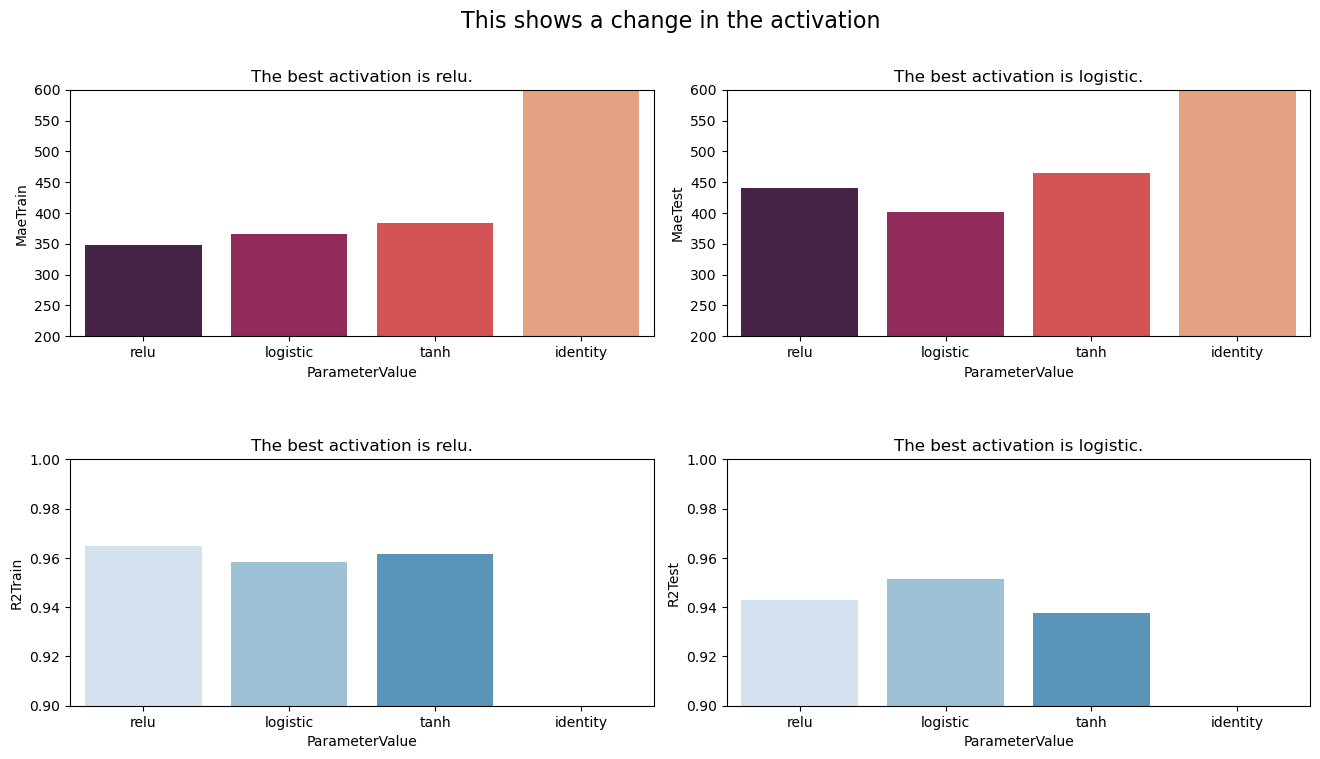

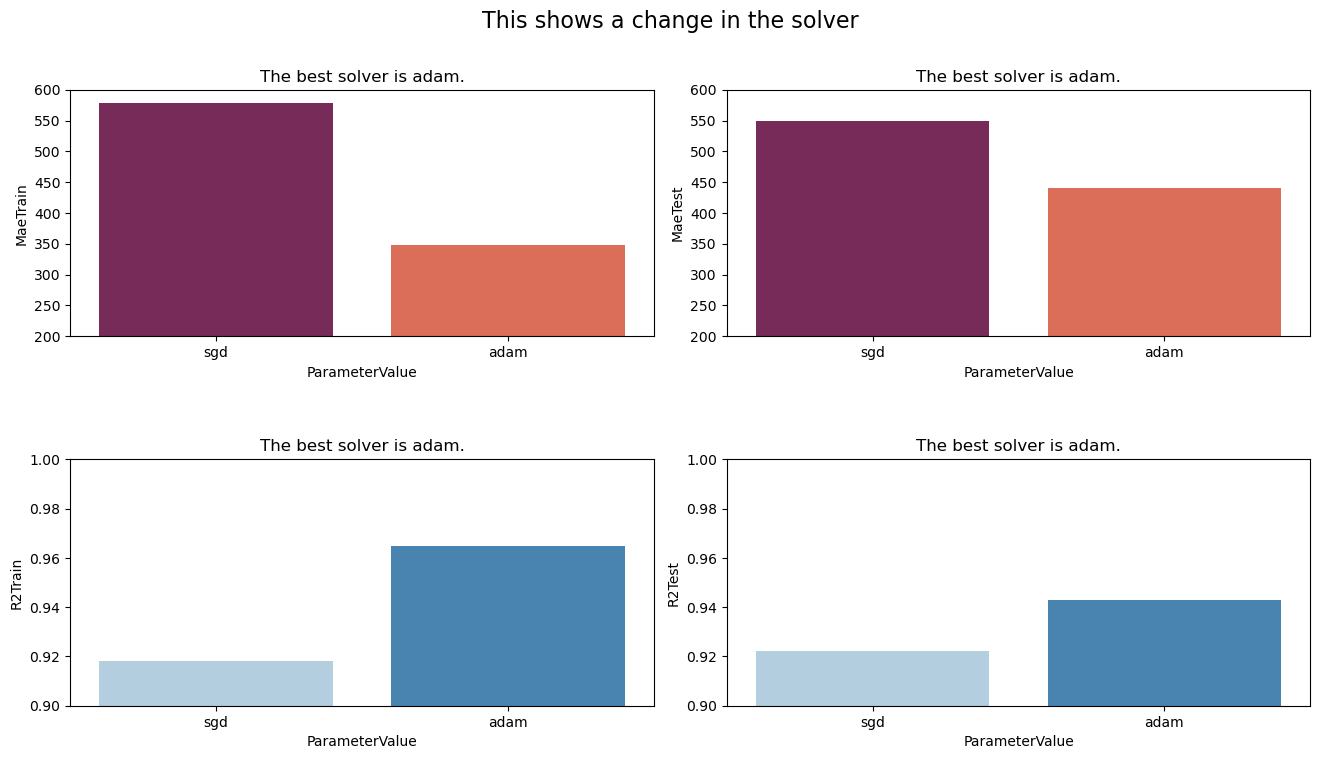

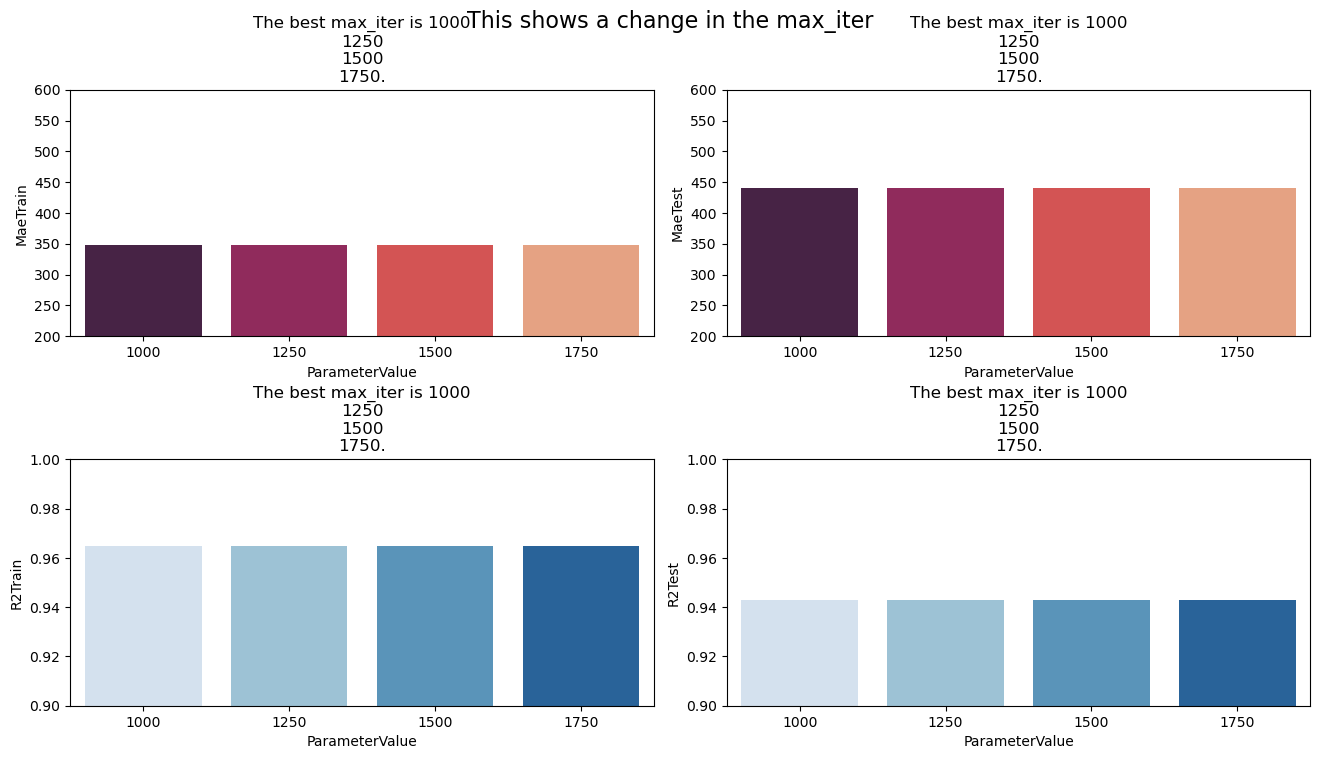

In [21]:
# defining a function for barplots for some of the parameters to compare mae and r2
def plot_bars(data_filter_model, data_filter_parameter):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter_parameter]

    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTrain", ax=mae_train_axes, palette="rocket")
    min_mae_train_df = plot_data[["ParameterValue", "MaeTrain"]]
    min_mae_train = min_mae_train_df["MaeTrain"].min()
    min_mae_train_df = min_mae_train_df[min_mae_train_df["MaeTrain"] == min_mae_train]
    min_mae_train = min_mae_train_df["ParameterValue"].to_string(index=False)
    mae_train_axes.set_title(f"The best {data_filter_parameter} is {min_mae_train}.")
    mae_train_axes.set_ylim(200, 600)

    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTest", ax=mae_test_axes, palette="rocket")
    min_mae_test_df = plot_data[["ParameterValue", "MaeTest"]]
    min_mae_test = min_mae_test_df["MaeTest"].min()
    min_mae_test_df = min_mae_test_df[min_mae_test_df["MaeTest"] == min_mae_test]
    min_mae_test = min_mae_test_df["ParameterValue"].to_string(index=False)
    mae_test_axes.set_title(f"The best {data_filter_parameter} is {min_mae_test}.")
    mae_test_axes.set_ylim(200, 600)

    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Train", ax=r2_train_axes, palette="Blues")
    max_r2_train_df = plot_data[["ParameterValue", "R2Train"]]
    max_r2_train = max_r2_train_df["R2Train"].max()
    max_r2_train_df = max_r2_train_df[max_r2_train_df["R2Train"] == max_r2_train]
    max_r2_train = max_r2_train_df["ParameterValue"].to_string(index=False)
    r2_train_axes.set_title(f"The best {data_filter_parameter} is {max_r2_train}.")
    r2_train_axes.set_ylim(0.9, 1)

    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Test", ax=r2_test_axes, palette="Blues")
    max_r2_test_df = plot_data[["ParameterValue", "R2Test"]]
    max_r2_test = max_r2_test_df["R2Test"].max()
    max_r2_test_df = max_r2_test_df[max_r2_test_df["R2Test"] == max_r2_test]
    max_r2_test = max_r2_test_df["ParameterValue"].to_string(index=False)
    r2_test_axes.set_title(f"The best {data_filter_parameter} is {max_r2_test}.")
    r2_test_axes.set_ylim(0.9, 1)

    fig.suptitle(f"This shows a change in the {data_filter_parameter}", fontsize=16)
    fig.subplots_adjust(hspace=0.5, wspace=0.125)
    fig.savefig(f"plots/{data_filter_model}_{data_filter_parameter}.png")

# apply the function to wanted parameters for comparison
plot_bars("MLP Regressor", "hidden_layer_size")
plot_bars("MLP Regressor", "activation")
plot_bars("MLP Regressor", "solver")
# plotting the iterations as a bar because there is no difference at the different iteration times if the rest is default
# it would not be possible to calculate the standardized version for the lineplot
plot_bars("MLP Regressor", "max_iter")

C:\Users\janag\AppData\Local\Temp\ipykernel_16032\1906951679.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["MaeTrain_std"] = standardize_df_col(plot_data["MaeTrain"])
C:\Users\janag\AppData\Local\Temp\ipykernel_16032\1906951679.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["MaeTest_std"] = standardize_df_col(plot_data["MaeTest"])
C:\Users\janag\AppData\Local\Temp\ipykernel_16032\1906951679.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

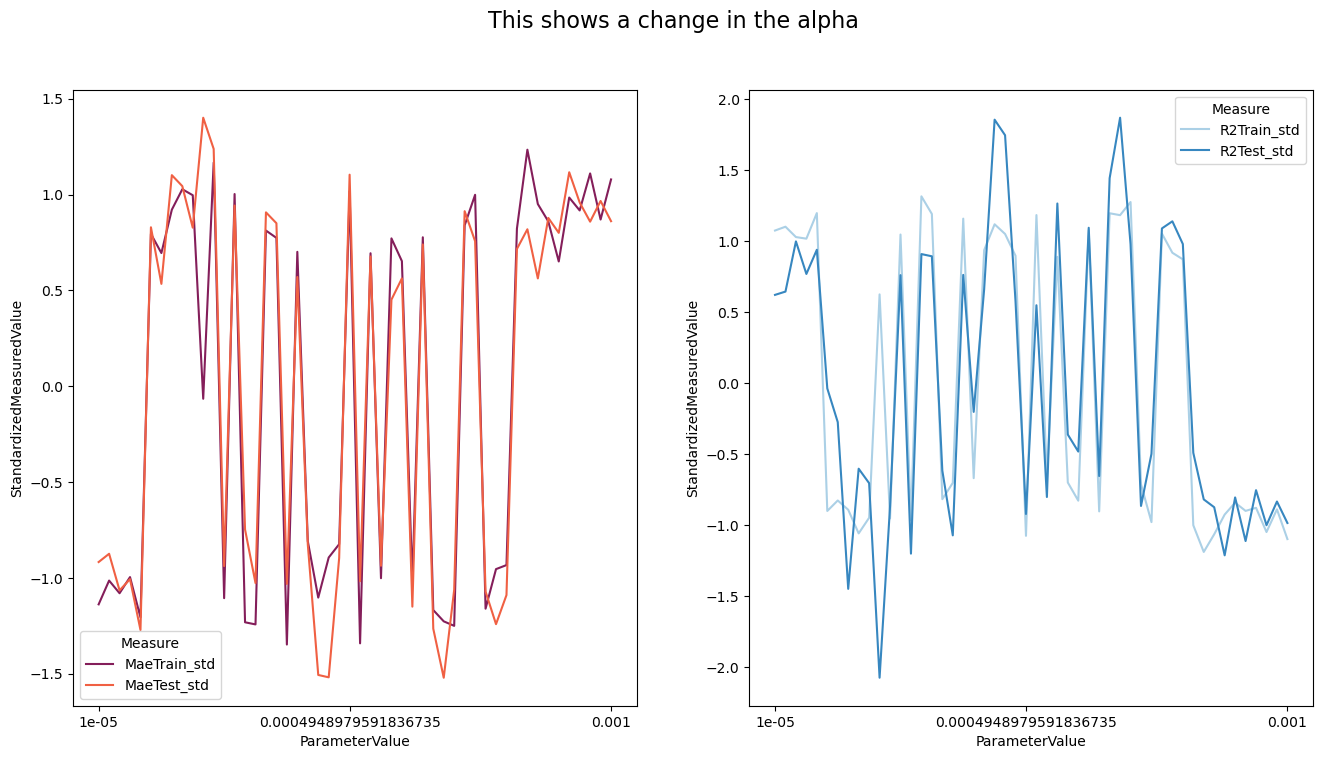

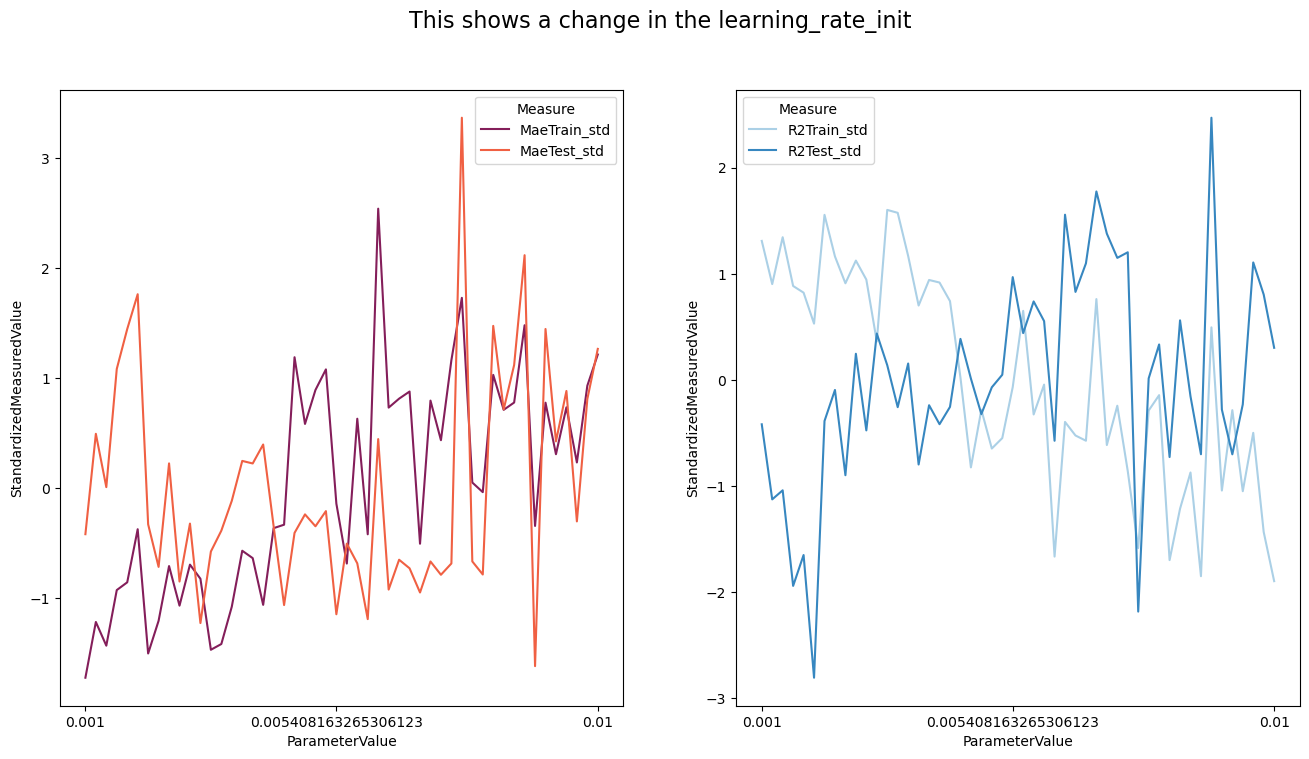

In [19]:
# Defining a function for standardization to have a better look at the change of the parameters
standardize_df_col = lambda df_c: (df_c - df_c.mean()) / df_c.std()

# Defining a function for lineplots for the parameters to compare mae and r2 for test and train data
def plot_lines(data_filter_model, data_filter_parameter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    # Filter the dataframe for the wanted Model and the wanted Parameter
    plot_data_all_param = param_testing[param_testing["Model"] == data_filter_model]
    plot_data = plot_data_all_param[plot_data_all_param["Parameter"] == data_filter_parameter]

    # Standardize the Values to see changes better and name them accordingly in new columns
    plot_data["MaeTrain_std"] = standardize_df_col(plot_data["MaeTrain"])
    plot_data["MaeTest_std"] = standardize_df_col(plot_data["MaeTest"])
    plot_data["R2Train_std"] = standardize_df_col(plot_data["R2Train"])
    plot_data["R2Test_std"] = standardize_df_col(plot_data["R2Test"])

    # Bring the data into a long format to plot them
    plot_data_std = pd.melt(plot_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain_std", "MaeTest_std", "R2Train_std", "R2Test_std"], value_name="StandardizedMeasuredValue")

    # Select the standadised mae data and plot them 
    mae_data = plot_data_std[plot_data_std["Measure"].isin(["MaeTrain_std", "MaeTest_std"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data_std[plot_data_std["Measure"].isin(["R2Train_std", "R2Test_std"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="StandardizedMeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    r2_axes.set_xticks([0, 24, 49])

    fig.suptitle(f"This shows a change in the {data_filter_parameter}", fontsize=16)
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.savefig(f"plots/{data_filter_model}_{data_filter_parameter}.png")

# apply the function to wanted parameters for comparison
plot_lines("MLP Regressor", "alpha")
plot_lines("MLP Regressor", "learning_rate_init")

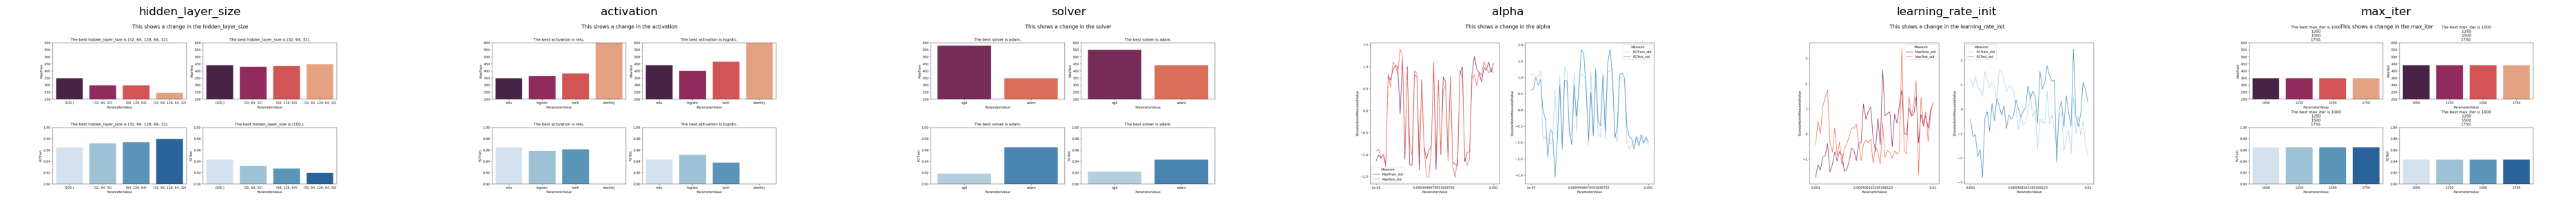

In [31]:
# Define a function to create figure frome saved pictures
def show_images_parameter(model, parameter_list):
    fig = plt.figure(figsize=(16, 8*len(parameter_list)))
    
    # Set the row and column number
    rows = 1
    columns = (len(parameter_list))
    
    # Go throug all parameters of the model
    i = 1
    for parameter in parameter_list:
        # Reading images
        img = Image.open(f"plots/{model}_{parameter}.png")
        # Adds a subplot at the i position
        fig.add_subplot(rows, columns, i)
        i += 1
        # Showing the Image
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{parameter}")
    

show_images_parameter("MLP Regressor", names_parameters)

### 3. Optimize the Hyperparameters with the Findings above

In [8]:
# subsetting the data for the optimization of the hyperparameters
ped_subset = ped.sample(frac=0.1, random_state=1)

# Define a new X of the subset with the squared feature k = 0.99, 57+46
X_subset = np.array(ped_subset[ped_subset.columns[57:103]])

# Subset of the output to predict
y_subset = ped_subset["pedestrians count"]

# Split the subset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)

In [9]:
# scale the data of the subset, so it is less sensitive to feature scaling 
# scale the inputs
scaler.fit(Xtrain_subset)
Xtrain_scaled_subset = scaler.transform(Xtrain_subset)
# apply the same transformation to the test data to have meaningful results
scaler.fit(Xtest_subset)
Xtest_scaled_subset = scaler.transform(Xtest_subset)
# scale the y different because we can't use standardscaler to a 1d array
mu_subset, sigma_subset = y_subset.mean(), y_subset.std()
ytest_scaled_subset = (ytest_subset - mu_subset) / sigma_subset
ytrain_scaled_subset = (ytrain_subset - mu_subset) /sigma_subset

In [10]:
# Definine a Base Model for the Subset
nnet_base_sub = MLPRegressor(random_state=42)
nnet_base_sub.fit(Xtrain_scaled_subset, ytrain_scaled_subset)

# Evaluate the basemodel for the Subset
scenario_fit_evaluate_scaled("MLP Regressor Subset", "Base Scenario", nnet_base_sub, 
    Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         MLP Regressor  Base Scenario  346.964702  458.804790  0.965150   
1  MLP Regressor Subset  Base Scenario  164.727363  943.799061  0.991575   

    R2_test  
0  0.940915  
1  0.812095  


In [30]:
# defining the model and the parameters used in RandomizedSearchCV
nnet_randomsearch = MLPRegressor(random_state=42)

parameters_randomsearch = {
    # choosing the two best hidden layer sizes and a range around them
    "hidden_layer_sizes": [(50,), (100,), (150,), (9, 18, 6), (32, 64, 32), (12, 24, 12)],
    "activation": ["logistic", "relu"], # choosing the two activation functions based on analysis above
    "solver": ["adam"], # adam was clearly the best solver in the plot above
    "alpha": np.linspace(0.00005, 0.0005, 20),
    "learning_rate_init" : np.linspace(0.0005, 0.001, 20),
    "max_iter" : range(1000, 2000, 100) # we look if the iterations have an efffect if there are other parameters that change
}

# Calculating the possibilities this gives us
length = [len(values) for key, values in parameters_randomsearch.items()]
print(f"In total we have {np.prod(length)} possibilities")

In total we have 48000 possibleties


In [32]:
# running the RandomizedSearchCV on the subset of the data
nnet_rndm_src = RandomizedSearchCV(estimator=nnet_randomsearch, param_distributions=parameters_randomsearch, cv=3)
nnet_rndm_src.fit(Xtrain_subset, ytrain_subset)
print(nnet_rndm_src.best_params_)
# {'solver': 'adam', 'max_iter': 1300, 'learning_rate_init': 0.0005, 'hidden_layer_sizes': (9, 18, 6), 'alpha': 0.00021578947368421054, 'activation': 'relu'}

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'solver': 'adam', 'max_iter': 1300, 'learning_rate_init': 0.0005, 'hidden_layer_sizes': (9, 18, 6), 'alpha': 0.00021578947368421054, 'activation': 'relu'}


c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
# creating a neural network with the results of the RandomSearchCV and the whole data and look at mae and r2
nnet_random = MLPRegressor(hidden_layer_sizes=(9, 18, 6), activation="relu", solver="adam", alpha=0.00021578947368421054,
    learning_rate_init=0.0005, max_iter=1300, random_state=42)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor Subset", "RandomSearch", nnet_random, Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         MLP Regressor  Base Scenario  346.964702  458.804790  0.965150   
1  MLP Regressor Subset  Base Scenario  164.727363  943.799061  0.991575   
2  MLP Regressor Subset   RandomSearch  422.899468  816.585346  0.958999   

    R2_test  
0  0.940915  
1  0.812095  
2  0.835115  


In [34]:
# use GridSearchCV to further optimize the parameters and run now all possibilities
# defining the model and the parameters used in GridSearchCV
nnet_gridsearch = MLPRegressor(random_state=42)

parameters_gridsearch = {
    "hidden_layer_sizes": [(9, 18, 6), (32, 64, 32)], # keeping (32, 64, 32) because it looked promising before and compare it to randomized optimum
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": np.append(np.linspace(0.0002, 0.0004, 3), [0.00021578947368421054]), # appending the best value of RandomSearch
    "learning_rate_init" : np.append(np.linspace(0.0004, 0.0006, 3), [0.0005]), # appending the best value of RandomSearch
    "max_iter" : range(1200, 1500, 100)
}


In [35]:
# running the GridSearchCV on the subset of the data
nnet_grid_src = GridSearchCV(estimator=nnet_gridsearch, param_grid=parameters_gridsearch, cv=3)
nnet_grid_src.fit(Xtrain_subset, ytrain_subset)
print(nnet_grid_src.best_params_)

# {'activation': 'relu', 'alpha': 0.00021578947368421054, 'hidden_layer_sizes': (32, 64, 32), 'learning_rate_init': 0.0006, 'max_iter': 1300, 'solver': 'adam'}

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\janag\miniconda3\en

{'activation': 'relu', 'alpha': 0.00021578947368421054, 'hidden_layer_sizes': (32, 64, 32), 'learning_rate_init': 0.0006, 'max_iter': 1300, 'solver': 'adam'}


c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# creating a neural network with the results of GridSearchCV and the whole data and look at mae and r2
nnet_grid = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam", alpha=0.00021578947368421054,
    learning_rate_init=0.0006, max_iter=1300, random_state=42)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor Subset", "GridSearch", nnet_grid, Xtrain_scaled_subset, ytrain_scaled_subset, Xtest_scaled_subset, ytest_scaled_subset)

                  Model       Scenario   MAE_train    MAE_test  R2_train  \
0         MLP Regressor  Base Scenario  346.964702  458.804790  0.965150   
1  MLP Regressor Subset  Base Scenario  164.727363  943.799061  0.991575   
2  MLP Regressor Subset   RandomSearch  422.899468  816.585346  0.958999   
3  MLP Regressor Subset     GridSearch  157.127540  939.964346  0.993650   

    R2_test  
0  0.940915  
1  0.812095  
2  0.835115  
3  0.816643  


## Comparing the results of the 3 neural networks

In [13]:
# reading the created dataframe and have a look at it to plot it later for the analysis
comparison = pd.read_csv("outputs/comparison_mae_r2.csv", sep=";")
comparison

,Model,Scenario,MAE_train,MAE_test,R2_train,R2_test
0,MLP Regressor,Base Scenario,346.964702,458.804790,0.965150,0.940915
1,MLP Regressor Subset,Base Scenario,164.727363,943.799061,0.991575,0.812095
2,MLP Regressor Subset,RandomSearch,422.899468,816.585346,0.958999,0.835115
3,MLP Regressor Subset,GridSearch,157.127540,939.964346,0.993650,0.816643


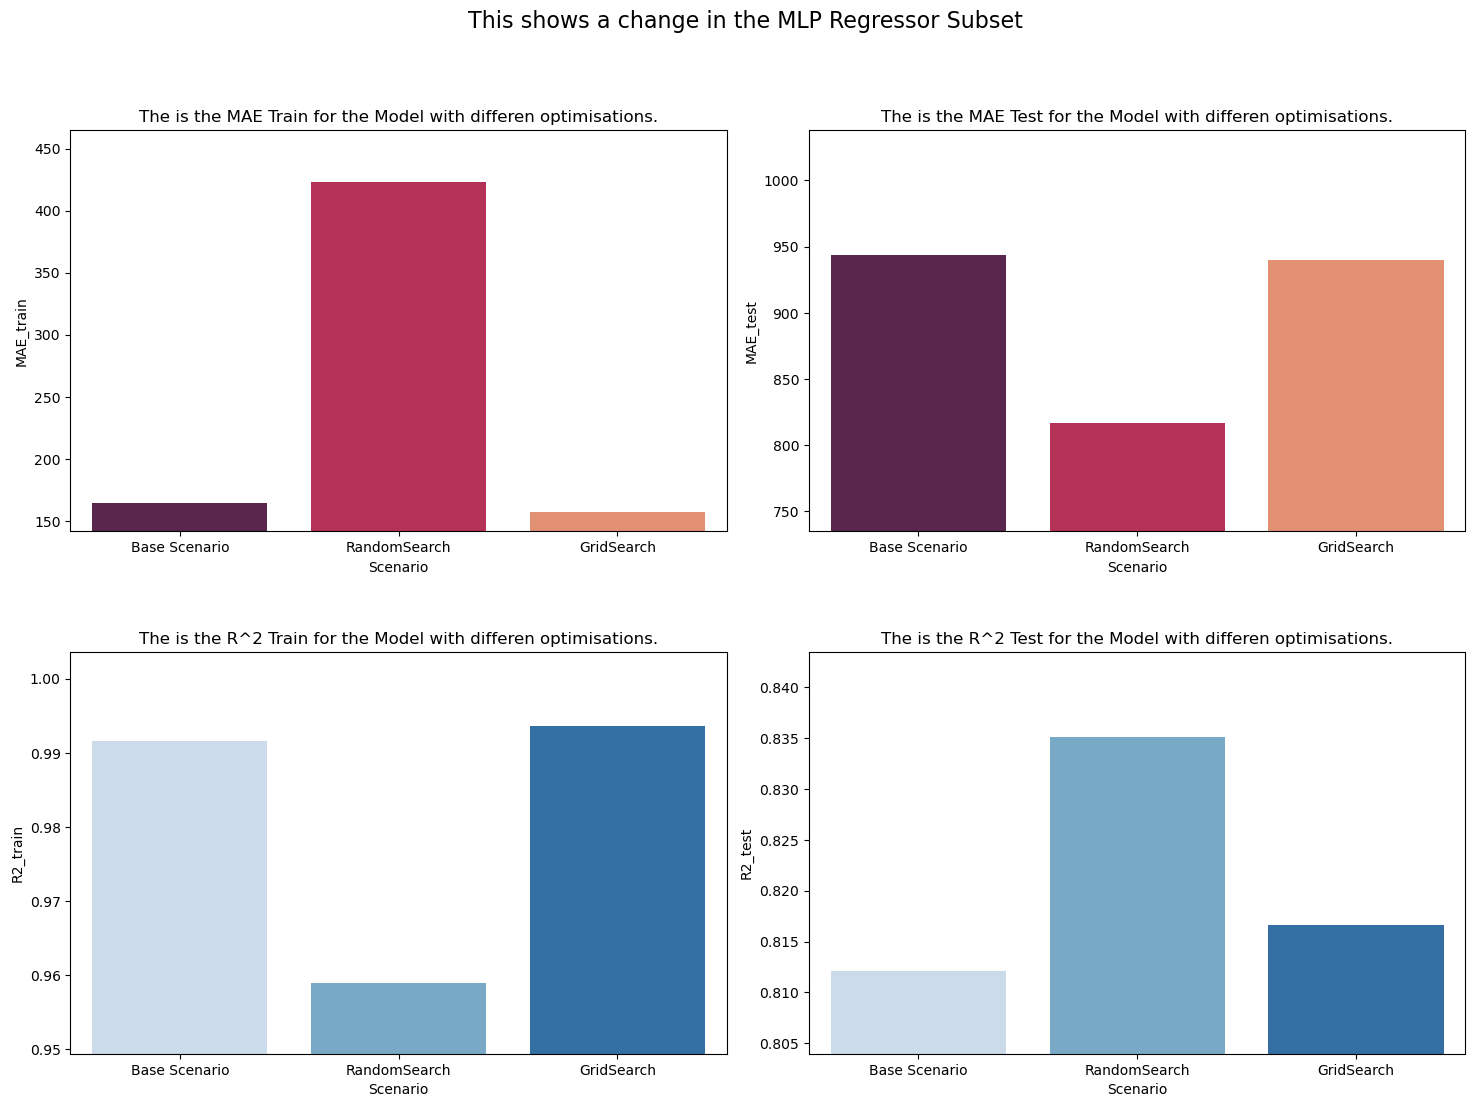

In [17]:
# Define a Function to plot the comparison of the models
def plot_bars_comp(model, dataframe):
    # Define the dimensions and model of the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_data = dataframe[dataframe["Model"] == model]

    # Get the MAE train bars
    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim((plot_data["MAE_train"].min())*0.9, (plot_data["MAE_train"].max())*1.1)
    mae_train_axes.set_title(f"The is the MAE Train for the Model with differen optimisations.")

    # Get the MAE test bars
    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim((plot_data["MAE_test"].min())*0.9, (plot_data["MAE_test"].max())*1.1)
    mae_test_axes.set_title(f"The is the MAE Test for the Model with differen optimisations.")


    # Get the r2 train bars
    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim((plot_data["R2_train"].min())*0.99, (plot_data["R2_train"].max())*1.01)
    r2_train_axes.set_title(f"The is the R^2 Train for the Model with differen optimisations.")


    # Get the r2 test bars
    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim((plot_data["R2_test"].min())*0.99, (plot_data["R2_test"].max())*1.01)
    r2_test_axes.set_title(f"The is the R^2 Test for the Model with differen optimisations.")

    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    # Set a Titel
    fig.suptitle(f"This shows a change in the {model}", fontsize=16)
    fig.savefig(f"plots/{model} comparison.png")


plot_bars_comp("MLP Regressor Subset", comparison)

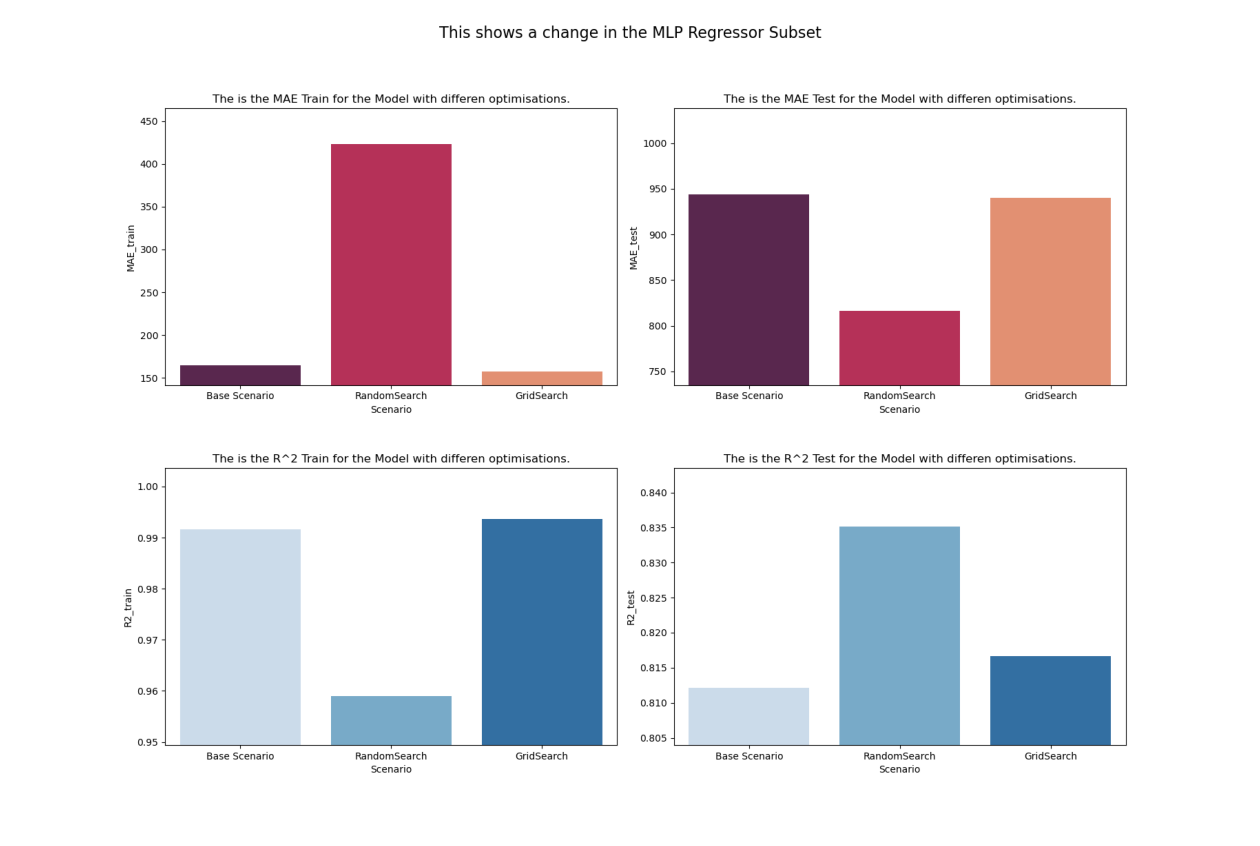

In [18]:

# Define a function to create figure frome saved pictures of the comaprison
def show_images_compa(model):
    fig = plt.figure(figsize=(16, 20))
    
    # Set the row and column number
    rows = 1
    columns = 1


    img = Image.open(f"plots/{model} comparison.png")
    # Adds a subplot at the i position
    fig.add_subplot(rows, columns, 1)

    # Showing the Image
    plt.imshow(img)
    plt.axis('off')
    

show_images_compa("MLP Regressor Subset")

### Optimization for the whole dataset

In [42]:
# Setting up the first Hyperparameters that should be tuned, due to the size of the Dataset only very few
# Number of trees in random forest
hidden_layer_sizes = [(9, 18, 6), (32, 64, 32)]
# to avoid overfittig
alpha = np.linspace(0.0002, 0.0004, 3)
# Method to controll complexity 
learning_rate_init = np.linspace(0.0004, 0.0006, 3)

param_grid = {"hidden_layer_sizes": hidden_layer_sizes,
               "alpha": alpha,
               "learning_rate_init": learning_rate_init}

param_standard = {"hidden_layer_sizes": (100,),
               "alpha": 0.0001,
               "learning_rate_init": 0.001}

In [58]:
# Although they are influencing each other, this is too much for my Comuter, a proper optimization is shown above with a 
# subset and Cross validation takes too much computing power, due to the lage data:

def optimize_parameter_scaled(parameter, param_values, param_values_fix1, param_valuesfix_2, Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled, initialize_model):
    for param_value in param_values:
        mae_test = []

        rf_param = initialize_model(param_value, param_values_fix1, param_valuesfix_2)
        
        # Fit the network to the train data
        rf_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_test_scaled = rf_param.predict(Xtest_scaled)
        ypred_test = ypred_test_scaled * sigma + mu

        # Compute the MAE
        mae_param_test = mean_absolute_error(ytest, ypred_test)


        # adding them in a list
        mae_test.append(mae_param_test)

    # getting the minimum values
    index_best = np.argmin(mae_test)
    best_parameter = param_values[index_best]

    return best_parameter


best_hidden_layer_size = optimize_parameter_scaled("hidden_layer_sizes", hidden_layer_sizes, 0.0001 , 0.001, Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled, 
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value, alpha=value_fix1, learning_rate_init=value_fix2, random_state=42))

best_alpha = optimize_parameter_scaled("alpha", alpha, best_hidden_layer_size, 0.001,  Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled,
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value_fix1, alpha=value, learning_rate_init=value_fix2, random_state=42))

best_learning_rate = optimize_parameter_scaled("learning_rate_init", learning_rate_init, best_hidden_layer_size, best_alpha,  Xtrain_scaled, Xtest_scaled, ytrain_scaled, ytest_scaled,
                    lambda value, value_fix1, value_fix2: MLPRegressor(hidden_layer_sizes=value_fix1, alpha=value_fix2, learning_rate_init=value, random_state=42))

print(f"The best MAE Test is given with, hidden_layer_sizes: {best_hidden_layer_size}, alpha: {best_alpha}, learning_rate_init: {best_learning_rate}")
# The best MAE Test is given with, hidden_layer_sizes: (9, 18, 6), alpha: 0.0002, learning_rate_init: 0.0004

The best MAE Test is given with, hidden_layer_sizes: (9, 18, 6), alpha: 0.0002, learning_rate_init: 0.0004


In [14]:
# creating a neural network with the results of this optimization to look at the mae and r2
nnet_optimized = MLPRegressor(random_state=42, hidden_layer_sizes= (9, 18, 6), alpha = 0.0002, learning_rate_init = 0.0004)

# fit the data and run the model with new parameters
scenario_fit_evaluate_scaled("MLP Regressor", "Partly optimisation", nnet_optimized, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)


                  Model             Scenario   MAE_train    MAE_test  \
0         MLP Regressor        Base Scenario  346.964702  458.804790   
1  MLP Regressor Subset        Base Scenario  164.727363  943.799061   
2  MLP Regressor Subset         RandomSearch  422.899468  816.585346   
3  MLP Regressor Subset           GridSearch  157.127540  939.964346   
4         MLP Regressor  Partly optimisation  415.745568  425.201081   

   R2_train   R2_test  
0  0.965150  0.940915  
1  0.991575  0.812095  
2  0.958999  0.835115  
3  0.993650  0.816643  
4  0.939840  0.940928  


In [15]:
# for comparison run the optimized parameters of the subset on the whole dataset and look at mae and r2
# fit the data and run the model with selected parameters
scenario_fit_evaluate_scaled("MLP Regressor", "GridSearch", nnet_grid, Xtrain_scaled, ytrain_scaled, Xtest_scaled, ytest_scaled)

                  Model             Scenario   MAE_train    MAE_test  \
0         MLP Regressor        Base Scenario  346.964702  458.804790   
1  MLP Regressor Subset        Base Scenario  164.727363  943.799061   
2  MLP Regressor Subset         RandomSearch  422.899468  816.585346   
3  MLP Regressor Subset           GridSearch  157.127540  939.964346   
4         MLP Regressor  Partly optimisation  415.745568  425.201081   
5         MLP Regressor           GridSearch  304.198428  441.389594   

   R2_train   R2_test  
0  0.965150  0.940915  
1  0.991575  0.812095  
2  0.958999  0.835115  
3  0.993650  0.816643  
4  0.939840  0.940928  
5  0.970655  0.932543  


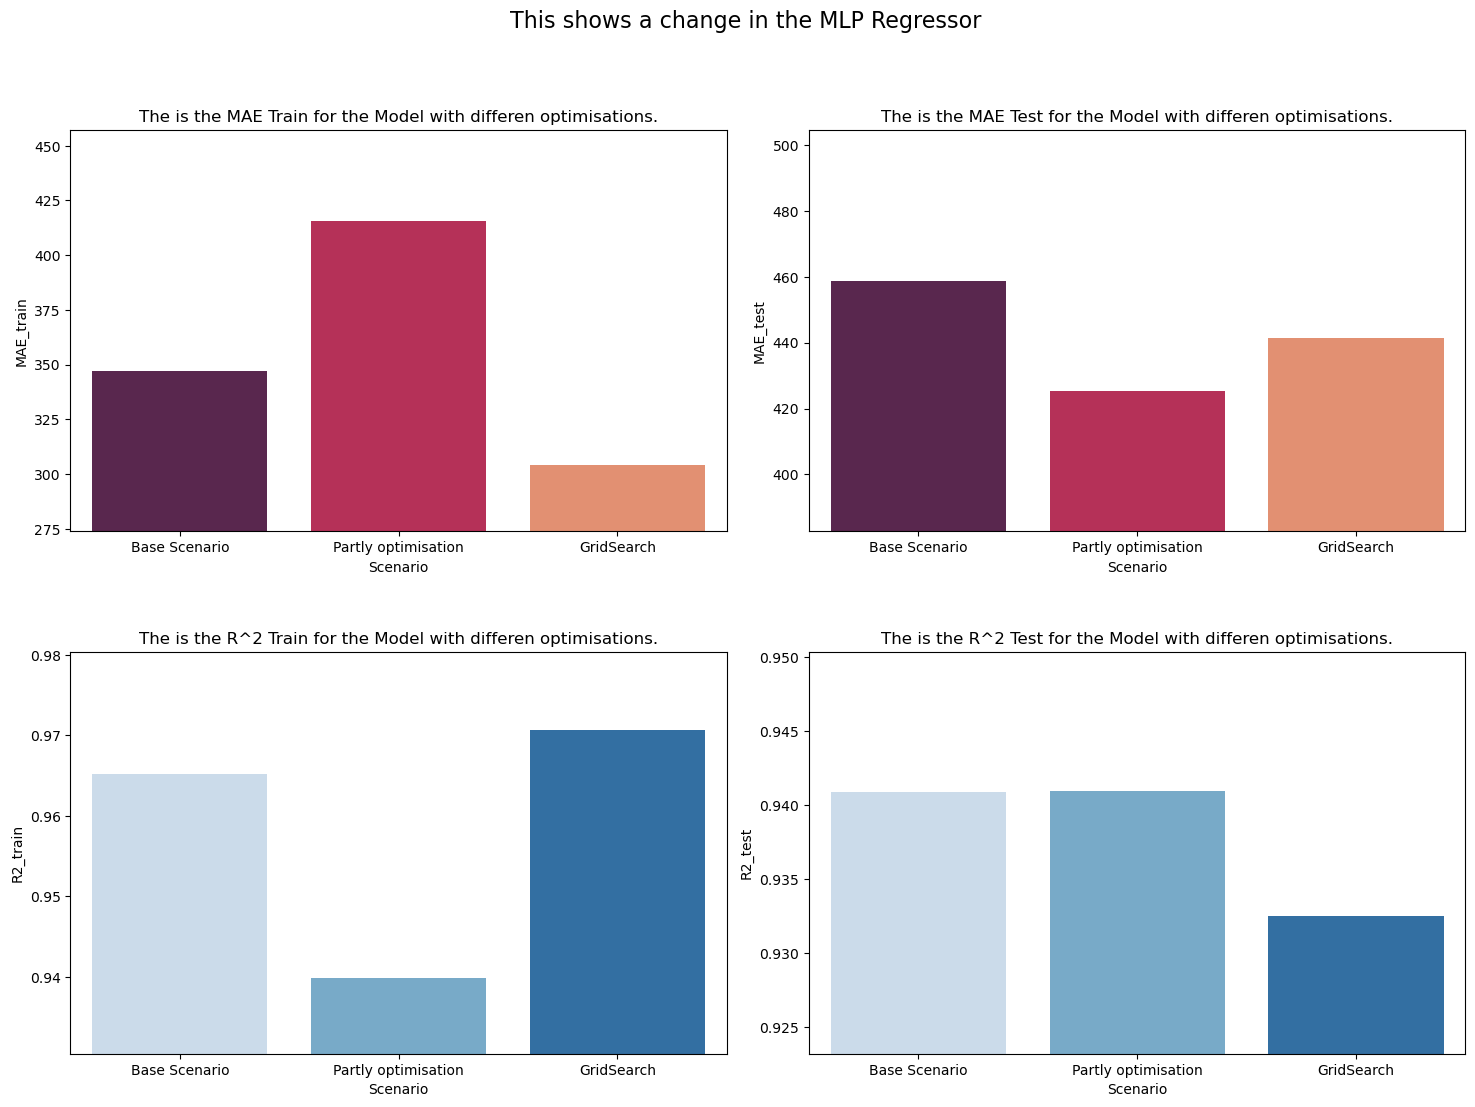

In [19]:
# plotting a comparison to the base model

plot_bars_comp("MLP Regressor", comparison)

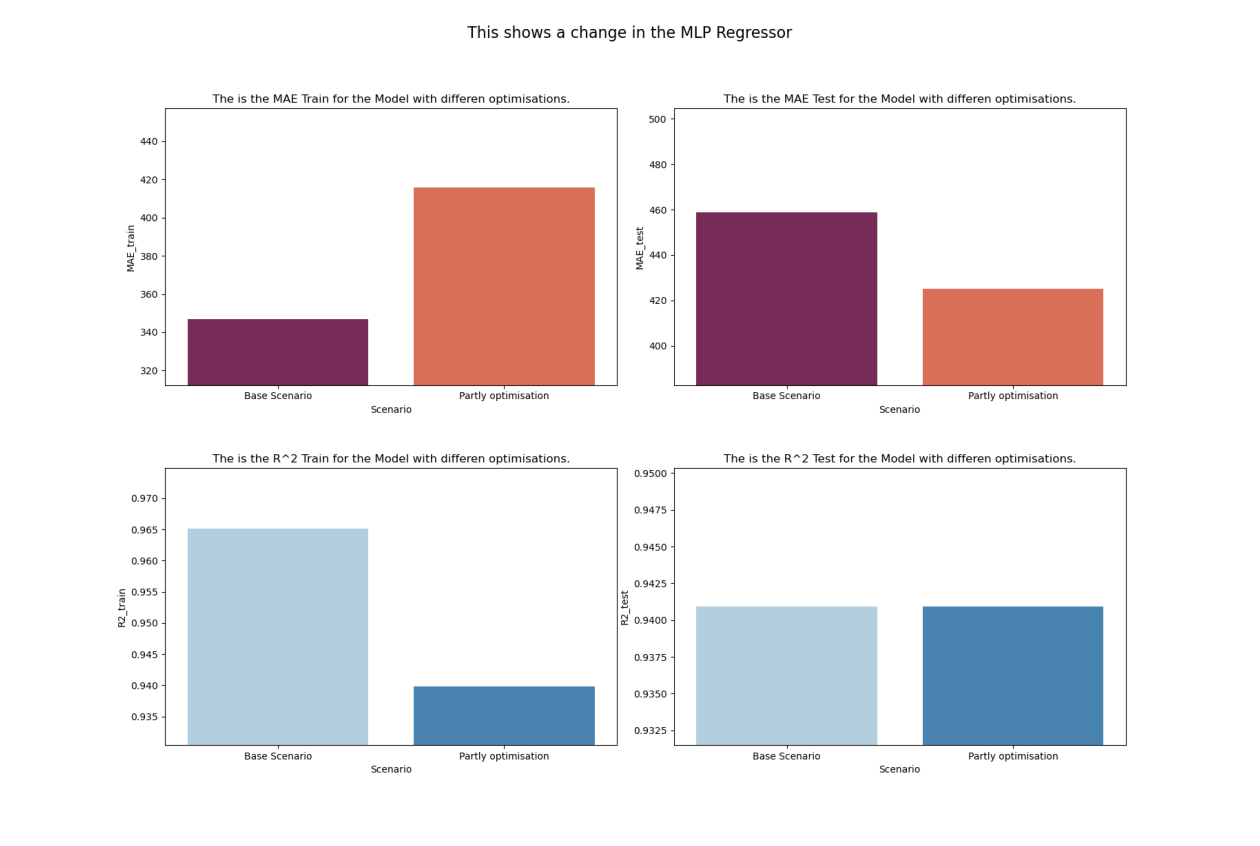

In [61]:
show_images_compa("MLP Regressor")